In [1]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[0])

import jax.numpy as jnp
from KernelTools import make_block,eval_k,vectorize_kfunc,diagpart,get_selected_grad
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel
from data_utils import build_xy_grid
from darcy_data import get_darcy_solver,sample_gp_function
from jax.random import PRNGKey as pkey
import matplotlib.pyplot as plt
from EquationModel import CholInducedRKHS,SharedOperatorPDEModel,InducedOperatorModel
from tqdm.auto import tqdm
from parabolic_data_utils import build_alpha_chebyshev
from data_utils import make_grids

In [2]:
num_functions = 20
samples_per_function = 10

obs_random_keys = jax.random.split(pkey(32),num_functions)
xy_obs = tuple(jax.random.uniform(key,(samples_per_function,2),minval = 0.,maxval = 1.) for key in obs_random_keys)


kernel_f = get_gaussianRBF(0.15)
key = pkey(10)
keys = jax.random.split(key,num_functions)
rhs_functions = tuple(
    sample_gp_function(subkey,kernel_f) for subkey in keys
)

grid = jnp.linspace(0,1,100)
x,y = jnp.meshgrid(grid,grid)
fine_grid = jnp.vstack([x.flatten(),y.flatten()]).T

def a(x):
    return 0.1 * jnp.exp(0.5 * jnp.sin(4*jnp.pi*x[0]*x[1]))

darcy_solve = get_darcy_solver(a,num_grid = 50,k_u = get_gaussianRBF(0.2))
u_true_functions = tuple([darcy_solve(f) for f in rhs_functions])

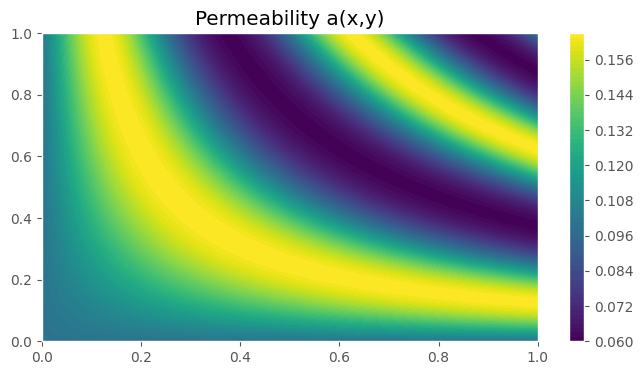

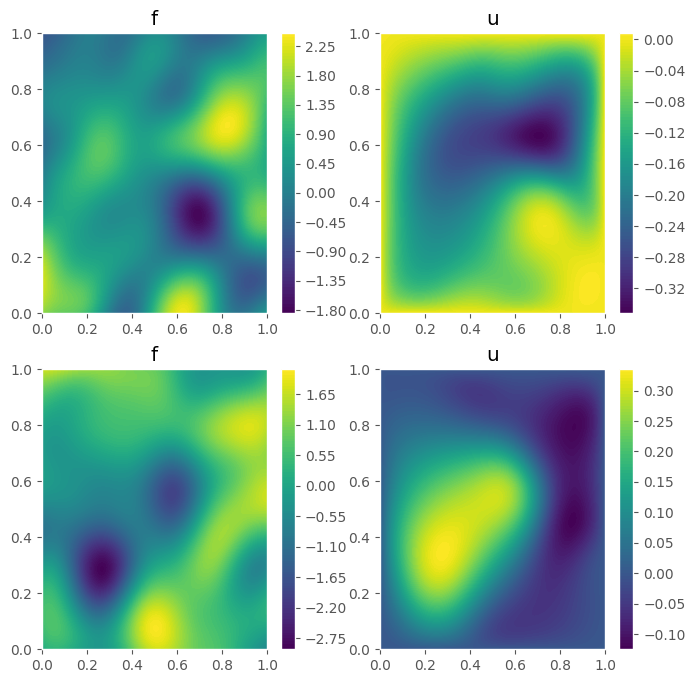

In [3]:
num_to_plot = 2
plt.figure(figsize=(8,4))
plt.title("Permeability a(x,y)")
plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(a)(fine_grid),100)
plt.colorbar()
plt.show()
plt.figure(figsize = (8,num_to_plot * 4))
for i in range(num_to_plot):
    plt.subplot(num_to_plot,2,2*i+1)
    plt.title("f")
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(rhs_functions[i])(fine_grid),100)
    plt.colorbar()
    plt.subplot(num_to_plot,2,2*(i+1))
    plt.title('u')
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(u_true_functions[i])(fine_grid),100)
    plt.colorbar()
plt.show()

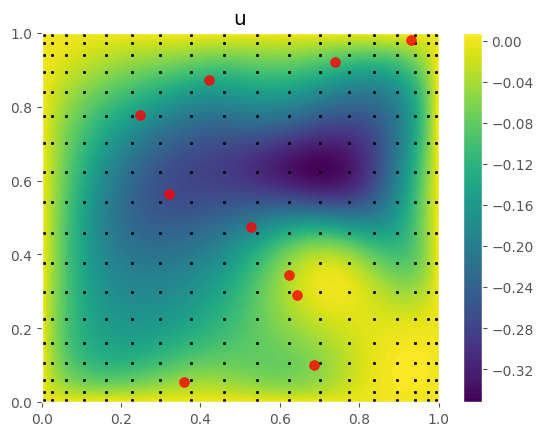

In [4]:
k_u = get_gaussianRBF(0.2)
# xy_int,xy_bdy=build_xy_grid([0,1],[0,1],20,20)

single_grid = build_alpha_chebyshev([0,1],20,1.)
xy_int,xy_bdy = make_grids(single_grid,single_grid)

xy_all = jnp.vstack([xy_int,xy_bdy])
plt.title('u')
plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(u_true_functions[0])(fine_grid),100)
plt.colorbar()
plt.scatter(xy_int[:,0],xy_int[:,1],c = 'black',s = 3)
plt.scatter(xy_obs[0][:,0],xy_obs[0][:,1],c = 'red',s = 50,alpha = 0.8)
plt.show()

In [6]:
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])
basis_operators = tuple([eval_k,diff_xx_op,diff_yy_op])

u_model = CholInducedRKHS(
    xy_all,
    basis_operators,
    k_u
)


observation_points = tuple(jnp.vstack([xy_bdy,obs]) for obs in xy_obs)
observation_values = tuple(jax.vmap(u)(obs_loc) for u,obs_loc in zip(u_true_functions,observation_points))
collocation_points = (xy_int,)*num_functions

rhs_values = tuple(jax.vmap(rhs_func)(int_points) for rhs_func,int_points in zip(rhs_functions,collocation_points))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val) 
    for obs_loc,obs_val in zip(observation_points,observation_values)
    ]
    )

In [7]:
grid_features_u_init = [(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for model_params in all_u_params_init
        ]
grid_features_u_init = jnp.vstack([jnp.hstack([xy_int,features]) for features in grid_features_u_init])

num_P_inducing = 250
input_feature_sample = jax.random.choice(pkey(320),grid_features_u_init,(num_P_inducing,))
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.25)
def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])

P_model = InducedOperatorModel(input_feature_sample,k_P)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

In [8]:
params_init = jnp.hstack(list(all_u_params_init)+[P_init])
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 10.,
    num_P_operator_params=num_P_inducing
)

In [ ]:
import jax.numpy as jnp
from jax.scipy.linalg import cholesky,cho_solve,solve
from tqdm.auto import tqdm
import time
from dataclasses import dataclass, field
from Optimizers.solvers_base import LMParams,ConvergenceHistory
from EquationModel import SharedOperatorPDEModel
import jax
from functools import partial

def setup_arrow_functions(model,beta_reg_u,beta_reg_P,datafit_weight):
    def single_function_residuals(
        u_param,
        P_params,
        single_collocation_points,
        single_rhs,
        single_observation_points,
        single_observation_values,
    ):
        datafit_res = model.datafit_residual_single(
            u_param,
            single_observation_points,
            single_observation_values,
        )
        eqn_res = model.equation_residual_single(
            u_param,
            P_params,
            single_collocation_points,
            single_rhs
        )
        return jnp.hstack([datafit_res*jnp.sqrt(datafit_weight/len(datafit_res)),eqn_res/jnp.sqrt(len(eqn_res))])

    stacked_colloc = jnp.stack(model.collocation_points)
    stacked_rhs = jnp.stack(model.rhs_forcing_values)
    stacked_obs_points = jnp.stack(model.observation_points)
    stacked_obs_values = jnp.stack(model.observation_values)
    data_args = [stacked_colloc,stacked_rhs,stacked_obs_points,stacked_obs_values]

    u_vmap_axes = (0,None,0,0,0,0)

    @jax.jit
    def full_loss(u_params,P_params):
        residuals = (
            jax.vmap(
                single_function_residuals,in_axes = u_vmap_axes
                )(
                    u_params,P_params,
                    *data_args
                    )
        )
        return 0.5 * (
            jnp.sum(residuals**2) + 
            beta_reg_P * jnp.sum(P_params**2) + 
            beta_reg_u * jnp.sum(u_params**2)
            )
        
    
    _jacU_func = jax.vmap(jax.jacrev(single_function_residuals,argnums = 0),in_axes=u_vmap_axes)

    @jax.jit
    def jacU(u_params,P_params):
        return _jacU_func(u_params,P_params,*data_args)
    
    _jacP_func = jax.vmap(jax.jacrev(single_function_residuals,argnums = 1),in_axes=u_vmap_axes)

    @jax.jit
    def jacP(u_params,P_params):
        return _jacP_func(u_params,P_params,*data_args)
    
    return full_loss,single_function_residuals,jacU,jacP,data_args

10.0

In [187]:
full_loss,single_function_residuals,jacU,jacP,data_args = (
    setup_arrow_functions(EqnModel,1e-12,1e-12,EqnModel.datafit_weight)
)
u_init = jnp.stack(all_u_params_init)

u_params = u_init
P_params = P_init

In [146]:
from jax.scipy.linalg import cholesky,solve

JU = jacU(u_init,P_init)
JP = jacP(u_init,P_init)
resF = jax.vmap(
    single_function_residuals,in_axes = (0,None,0,0,0,0)
    )(u_params,P_params,*data_args)

alpha = 1e-3
beta_reg_u = 1e-12
beta_reg_P = 1e-12

#Variables used below:
#JU, JP, resF, u_params,P_params, alpha

#build RHS vectors
Fp = jnp.sum(
    jax.vmap(lambda J,f:J.T@f)(JP,resF),axis=0
)+beta_reg_P*P_params

Fu = jax.vmap(lambda J,f,up:J.T@f + beta_reg_u*up)(JU,resF,u_params)

#Build normal equation matrices
Ap = jnp.sum(jax.vmap(lambda J:J.T@J)(JP),axis=0)
Ap = Ap + (alpha + beta_reg_P)*jnp.eye(len(Ap))

Du = jax.vmap(lambda a:a.T@a + (alpha + beta_reg_P)*jnp.eye(len(a[0])))(JU)

#Cholesky factor Du since we have two solves with it
cholDu = jax.vmap(lambda A:cholesky(A))(Du)

#Compute Bup = Jp.T@ Ju
Bup = jax.vmap(lambda Ju,Jp:Ju.T@Jp)(JU,JP)

#Compute Schur complement S
S = Ap - jnp.sum(
    jax.vmap(lambda b,d:b.T@(cho_solve((d,False),b)))(Bup,cholDu),axis=0
)

#Compute rhs piece
BDFu = jnp.sum(
    jax.vmap(lambda b,d,f:b.T@cho_solve((d,False),f))(Bup,cholDu,Fu),axis=0
)

#Compute steps in P and u from block matrix inversion
P_step = solve(S,Fp - BDFu,assume_a = 'pos')
u_step = jax.vmap(
    lambda d,f:cho_solve((d,False),f))(cholDu,Fu - (Bup@P_step))

In [147]:
previous_loss = full_loss(u_params,P_params)

updated_u = u_params - u_step
updated_P = P_params - P_step

#Compute step and if we decreased loss
new_loss = full_loss(updated_u,updated_P)

Jstep = jax.vmap(lambda j,u:j@u)(JU,u_step) + jax.vmap(lambda j,p:j@p,in_axes = (0,None))(JP,P_step)
new_reg_norm = (1/2) * (beta_reg_P * jnp.sum(updated_P**2) + beta_reg_u * jnp.sum(updated_u**2))

predicted_loss = (1/2)*(jnp.sum((Jstep - resF)**2)) + new_reg_norm

improvement_ratio = (previous_loss - new_loss)/(previous_loss - predicted_loss)

In [148]:
improvement_ratio

Array(0.87466793, dtype=float64)

In [149]:
jnp.sum((Jstep - resF)**2)

Array(0.1547685, dtype=float64)

In [150]:
predicted_loss

Array(0.07738425, dtype=float64)

In [155]:
full_loss(u_params - u_step,P_params - P_step)

Array(0.58902117, dtype=float64)

In [156]:
full_loss(u_params,P_params)

Array(4.15963496, dtype=float64)

In [188]:
def BlockArrowLM(
        u_init,
        P_init,
        model:SharedOperatorPDEModel,
        beta_reg_u:float = 1e-12,
        beta_reg_P:float = 1e-12, optParams: LMParams = LMParams() 
        ):
    """Adaptively regularized Levenberg Marquardt optimizer
    Parameters
    ----------
    init_params : jax array
        initial guess
    model :
        Object that contains model.F, and model.jac, and model.damping_matrix
    beta : float
        (global) regularization strength
    optParams: LMParams
        optimizer hyperparameters

    Returns
    -------
    solution
        approximate minimizer
    convergence_dict
        dictionary of data tracking convergencef """
    u_params = u_init
    P_params = P_init
    full_loss,single_function_residuals,jacU,jacP,data_args = (
        setup_arrow_functions(model,beta_reg_u,beta_reg_P,model.datafit_weight)
    )
    #We're being pretty sloppy with flops here
    #calling the loss and grad separately, and then 
    #building the rhs again (essentially also grad)
    grad_loss = jax.jit(jax.grad(full_loss))


    conv_history = ConvergenceHistory(track_iterates=False)
    start_time = time.time()
    alpha = optParams.init_alpha
    loss = full_loss(u_params,P_params)

    conv_history.update(
        loss = loss,
        gradnorm = jnp.linalg.norm(grad_loss(u_params,P_params)),
        iterate = None,
        armijo_ratio = 1.,
        alpha = alpha,
        cumulative_time = time.time() - start_time,
        linear_system_rel_residual=0.
    )

    @jax.jit
    def evaluate_objective(u_params,P_params):
        JU = jacU(u_params,P_params)
        JP = jacP(u_params,P_params)
        resF = jax.vmap(
            single_function_residuals,in_axes = (0,None,0,0,0,0)
            )(u_params,P_params,*data_args)

        #build RHS vectors
        Fp = jnp.sum(
            jax.vmap(lambda J,f:J.T@f)(JP,resF),axis=0
        )+beta_reg_P*P_params

        Fu = jax.vmap(lambda J,f,up:J.T@f + beta_reg_u*up)(JU,resF,u_params)
        return JU, JP, resF, Fp, Fu
    
    @jax.jit
    def compute_step(u_params,P_params,JU,JP,resF,Fp,Fu,alpha,previous_loss):
        #build RHS vectors
        Fp = jnp.sum(
            jax.vmap(lambda J,f:J.T@f)(JP,resF),axis=0
        )+beta_reg_P*P_params
        Fu = jax.vmap(lambda J,f,up:J.T@f + beta_reg_u*up)(JU,resF,u_params)

        #Build normal equation matrices
        Ap = jnp.sum(jax.vmap(lambda J:J.T@J)(JP),axis=0)
        Ap = Ap + (alpha + beta_reg_P)*jnp.eye(len(Ap))
        Du = jax.vmap(lambda a:a.T@a + (alpha + beta_reg_P)*jnp.eye(len(a[0])))(JU)

        #Cholesky factor Du since we have two solves with it
        cholDu = jax.vmap(lambda A:cholesky(A))(Du)
        #Compute Bup = Jp.T@ Ju
        Bup = jax.vmap(lambda Ju,Jp:Ju.T@Jp)(JU,JP)
        #Compute Schur complement S
        S = Ap - jnp.sum(
            jax.vmap(lambda b,d:b.T@(cho_solve((d,False),b)))(Bup,cholDu),axis=0
        )
        #Compute rhs piece
        BDFu = jnp.sum(
            jax.vmap(lambda b,d,f:b.T@cho_solve((d,False),f))(Bup,cholDu,Fu),axis=0
        )
        #Compute steps in P and u from block matrix inversion
        P_step = solve(S,Fp - BDFu,assume_a = 'pos')
        u_step = jax.vmap(
            lambda d,f:cho_solve((d,False),f)
            )(cholDu,Fu - (Bup@P_step))
        
        updated_u = u_params - u_step
        updated_P = P_params - P_step

        #Track the linear system residual
        linear_error = jnp.linalg.norm(Ap@P_step + jnp.sum(jax.vmap(lambda M,u: M.T@u)(Bup,u_step),axis = 0) - Fp)**2
        linear_error = linear_error + jnp.linalg.norm(
            (Bup@P_step) + jax.vmap(lambda d,u:d@u)(Du,u_step) - Fu
        )**2
        
        gradnorm = jnp.sqrt(jnp.linalg.norm(Fp)**2 + jnp.linalg.norm(Fu)**2)
        linear_system_rel_residual = (
            jnp.sqrt(linear_error)/gradnorm
        )

        #Compute step and if we decreased loss
        new_loss = full_loss(updated_u,updated_P)

        Jstep = jax.vmap(lambda j,u:j@u)(JU,u_step) + jax.vmap(lambda j,p:j@p,in_axes = (0,None))(JP,P_step)
        new_reg_norm = (1/2) * (beta_reg_P * jnp.sum(updated_P**2) + beta_reg_u * jnp.sum(updated_u**2))

        predicted_loss = (1/2)*(jnp.sum((Jstep - resF)**2)) + new_reg_norm

        improvement_ratio = (previous_loss - new_loss)/(previous_loss - predicted_loss)

        return updated_u,updated_P,new_loss,improvement_ratio,linear_system_rel_residual,gradnorm

    def LevenbergMarquadtUpdate(u_params,P_params,alpha,previous_loss):
        JU, JP, resF, Fp, Fu = evaluate_objective(u_params,P_params)
        alpha =jnp.clip(alpha,optParams.min_alpha,optParams.max_alpha)
        
        for i in range(optParams.max_line_search_iterations):
            updated_u,updated_P,new_loss,improvement_ratio,linear_system_rel_residual,gradnorm = (
                compute_step(u_params,P_params,JU,JP,resF,Fp,Fu,alpha,previous_loss)
            )
            if improvement_ratio >= optParams.cmin:
                #Check if we get at least some proportion of predicted improvement from local model
                succeeded = True
                return updated_u,updated_P, new_loss, gradnorm, improvement_ratio,alpha,linear_system_rel_residual,succeeded
            else:
                alpha = optParams.line_search_increase_ratio * alpha
            succeeded = False
        return updated_u,updated_P, new_loss, gradnorm, improvement_ratio,alpha,linear_system_rel_residual,succeeded

    for i in tqdm(range(optParams.max_iter)):
        u_params,P_params, loss, gradnorm, improvement_ratio,alpha,linear_system_rel_residual,succeeded = (
            LevenbergMarquadtUpdate(u_params,P_params,alpha,loss)
        )
        # Get new value for alpha
        multiplier = optParams.step_adapt_multiplier
        if improvement_ratio <= 0.2:
            alpha = multiplier * alpha
        if improvement_ratio >= 0.8:
            alpha = alpha/multiplier

        if succeeded==False:
            print("Line Search Failed!")
            print("Final Iteration Results")
            print(
                f"Iteration {i}, loss = {loss:.4},"
                f" gradnorm = {conv_history.gradnorm[-1]:.4}, alpha = {alpha:.4},"
                f" improvement_ratio = {improvement_ratio:.4}"
                )
            conv_history.finish()
            return u_params,P_params,conv_history

        conv_history.update(
            loss = loss,
            gradnorm = gradnorm,
            iterate = None,
            armijo_ratio = improvement_ratio,
            alpha = alpha,
            cumulative_time = time.time() - start_time,
            linear_system_rel_residual = linear_system_rel_residual
        )

        if conv_history.gradnorm[-1]<=optParams.tol:
            break
        if i%optParams.print_every ==0 or i<=5 or i == optParams.max_iter:
            print(
                f"Iteration {i}, loss = {loss:.4},"
                f" gradnorm = {conv_history.gradnorm[-1]:.4}, alpha = {alpha:.4},"
                f" improvement_ratio = {improvement_ratio:.4}"
                )
            if optParams.callback:
                optParams.callback(u_params,P_params)
    conv_history.finish()
    return u_params,P_params,conv_history


In [189]:
u_sol,P_sol,conv_history = BlockArrowLM(u_params,P_params,EqnModel)

  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 1.478, gradnorm = 7.943, alpha = 2.5, improvement_ratio = 0.9988
Iteration 1, loss = 0.9534, gradnorm = 2.039, alpha = 2.083, improvement_ratio = 1.04
Iteration 2, loss = 0.6932, gradnorm = 1.07, alpha = 1.736, improvement_ratio = 1.043
Iteration 3, loss = 0.5333, gradnorm = 0.7211, alpha = 1.447, improvement_ratio = 1.039
Iteration 4, loss = 0.4263, gradnorm = 0.5199, alpha = 1.206, improvement_ratio = 1.034
Iteration 5, loss = 0.3501, gradnorm = 0.3885, alpha = 1.005, improvement_ratio = 1.03
Iteration 50, loss = 0.002568, gradnorm = 0.01675, alpha = 0.0002747, improvement_ratio = 0.9817
Iteration 100, loss = 8.075e-05, gradnorm = 0.000177, alpha = 8.333e-07, improvement_ratio = 0.9982
Iteration 150, loss = 6.18e-05, gradnorm = 7.515e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 5.55e-05, gradnorm = 2.249e-06, alpha = 8.333e-07, improvement_ratio = 1.0


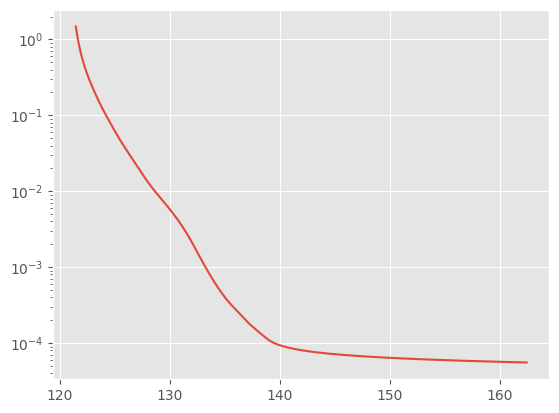

In [190]:
plt.plot(conv_history.cumulative_time[1:],conv_history.loss_vals[1:])
plt.yscale('log')